In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

In [ ]:
import os
os.chdir('/content/drive/MyDrive/BendeskyLab/2FishEncounterDL')

Tail Extraction

In [ ]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from scipy.ndimage import zoom  
from contour_utils import *
from find_features import features
from scipy import sparse
from LoopingArray import LoopingArray
import pickle
import matplotlib.pyplot as plt
import os

Functions for extracting contour and tail position

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  2 11:39:13 2020

@author: ryan
"""

#vidcap = cv2.VideoCapture("TailBeatingExamples/Copy of IM1_IM2_2.1.1_L.mp4")
#success,image=vidcap.read()


#find a conservative mask to exclude reflections and noises
def find_contour(videopath,head,length=40*300,start=0,step=1,pre_filter=None,threshold = 50,shrink_kernel = 3):
    '''
    prefilter:a function that changes mask array
    length: Total number of frames needed
    start: which frame to start
    step:pick every * frame
    thres: thresholding parameter when doing cv2.threshold
    shrink_kernel: how much you want to shrink the thresholded mask to avoid reflections
    '''
    vidcap = cv2.VideoCapture(videopath)
    contour_array=[]
    length=int(length/step)
    index=start
    vidcap.set(1,index)
    first = True
    for i in tqdm(range(length)):
        success,image=vidcap.read()
        if success!=1:
            print("process stops early at {}th iteration".format(i))
            break
        if pre_filter is not None:
            image = pre_filter(image)
        #plt.figure()
        #plt.imshow(image)
        index+=step
        vidcap.set(1,index)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #plt.figure()
        #plt.imshow(gray,"gray")
        ret,th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        #th=cv2.GaussianBlur(th, (3, 3), 0)
        #first shrink the mask to get it separate from its reflection
        if shrink_kernel>0:
          k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (shrink_kernel,shrink_kernel))
          th = cv2.dilate(th, k2, iterations=1)
        #plt.figure()
        #plt.imshow(th,"gray")
        #filter specific large black area, like 888 sign in other videos
        contours, hierarchy = cv2.findContours(np.invert(th.copy()), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)#simplified contour pts
        #finding the contour with largest area
        fish_contour,flag=find_largest_contour(contours)
        if flag==0:
            print("no valid fish contour find at index {}".format(i))
            img=np.float32(np.full(image.shape,0))#just in case there's no valid contour, won't happen in the current case
        else:
            #draw only the mask of this contour
            img=cv2.drawContours(np.float32(np.full(image.shape,255)),[fish_contour],0,(0,0,0),cv2.FILLED)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #img=np.invert(np.array(img,np.uint8))
        #zoom the mask a little bit because we shrink it before
        if shrink_kernel>0:
          k3=cv2.getStructuringElement(cv2.MORPH_RECT, (shrink_kernel+2,shrink_kernel+2))
        else:
          k3=cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        img=np.invert(np.array(cv2.erode(img,k3,iterations=1),np.uint8))
        #smoothing
        img=cv2.medianBlur(img, 5)
        true_contour, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)#complete contour pts
        true_contour,flag=find_largest_contour(true_contour)
        if flag == 0:
          contour_array.append(np.random.randn(100,1,2))
          continue
        conservative_mask = np.array(cv2.drawContours(np.float32(np.full((img.shape[0],img.shape[1]),255)),[true_contour],0,(0,0,0),cv2.FILLED),np.uint8)
        conservative_contour = true_contour
        #re-thresholding image and try to include tail into the contour
        ret,th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        k1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        th = cv2.erode(th, k1, iterations=1)

        xbar,ybar=find_centroid(conservative_contour)
        dists=compute_dist(conservative_contour,xbar,ybar)
        thres=np.quantile(dists,0.4)
        y,x=np.nonzero(np.invert(th))#black area, i.e. fish body
        head_x=head.x.iloc[i]
        head_y=head.y.iloc[i]
        th=exclusion(y,x,thres,xbar,ybar,head_x,head_y)           
        th=np.minimum(th,conservative_mask)
        th=np.invert(th)
        contours, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        fish_contour,flag=find_largest_contour(contours)
        if flag==0:
            print("no valid fish contour find at index {}".format(index-1))
            img=np.float32(np.full(image.shape,0))#just in case there's no valid contour, won't happen in the current case
        else:
            img=cv2.drawContours(np.float32(np.full(image.shape,255)),[fish_contour],0,(0,0,0),cv2.FILLED)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #to get rid of small holes in the mask
        k3=cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        img=np.invert(np.array(cv2.erode(img,k3,iterations=1),np.uint8))
        img=cv2.medianBlur(img, 5)
        true_contour, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)#complete contour pts
        true_contour,_=find_largest_contour(true_contour,interpolate=1)
        try:
            contour_array.append(true_contour)
        except:
            contour_array.append(np.zeros((1,1,2),dtype=np.float64))
        
        if first: #plot sample contour 
            sample_image = cv2.drawContours(image.copy(),[true_contour],0,(255,0,0),2)
            plt.imshow(sample_image)
            plt.savefig("sample_contour.png")
            print("sample contour of the first frame has been saved to sample_contour.png")
            first = False
        
    return contour_array
def exclusion(y,x,thres,xbar,ybar,head_x,head_y):
    dists1=compute_dist(np.vstack([x,y]).T,xbar,ybar)
    #new found part should not be too close to the centroid(as it is tail)
    flag1=dists1<thres
    dists2=compute_dist(np.vstack([x,y]).T,head_x,head_y)
    #new found part shall not be too close to the head, otherwise it is likely a reflection
    flag2=dists2<thres
    flag=np.logical_or(flag1,flag2)
    x=x[~flag]
    y=y[~flag]
    data=np.full((len(x),),255)
    output=np.invert(np.uint8(sparse.coo_matrix((data,(y,x)),shape=(IMAGELENGTH,IMAGELENGTH)).toarray()))
    return output 

def head_on_contour(head_x,head_y,contour):
    dists=compute_dist(contour,head_x,head_y)
    index=np.argmin(dists)
    return index

def compute_cos_fullbody(contour, step=30):
    #compute the curvature for full body
    curviness=np.zeros((0,3),dtype=np.float64)
    contour=contour.squeeze()
    N = len(contour)
    def find_next(i,step):
        return contour[(i+step) % N]
    def find_prev(i,step):
        return contour[(i -step) % N]
    for i in range(N):
        x_cur, y_cur = contour[i]
        x_next, y_next = find_next(i,step)
        x_prev, y_prev = find_prev(i,step)
        vec1=np.array([x_next-x_cur,y_next-y_cur])
        vec2=np.array([x_prev-x_cur,y_prev-y_cur])
        cos=np.sum(vec1*vec2)/np.sqrt(np.sum(vec1*vec1)*np.sum(vec2*vec2))
        curviness=np.concatenate((curviness,np.array([x_cur,y_cur,cos+1]).reshape(1,3)))
    return curviness

def averageBlur(arr,neighbor_width=30):
    #updating an array of curviness, make every element to the avg valye of its neighbor
    #So the tail tip is more likely to get a higher score compared to its neighbors
    out=arr.copy()
    l=len(arr)
    for i in range(l):
        out[i]=np.sum(LoopingArray(arr)[(i-neighbor_width):i+neighbor_width+1])/(2*neighbor_width+1)
    return out

#after the runlengthEncoding on validity derived from distance to centroid,
#some segments should be combined into longer segments
def combine_small_segment(value,length,minimal_length=70):
    l=len(value)
    flag=0
    #check if the starting point is a flipping point
    if value[0]==value[l-1]:
        temp=length[l-1]
        flag=1
        length[0]+=temp
        value=value[:l-1]
        length=length[:l-1]
    new_val=[]
    new_length=[]
    stack=0
    for i in range(len(value)):
        ll=length[i]
        #if the segment is smaller than certain length, put it to a existing segment
        #if there is no such thing, prepare that for a future valid segment
        if ll<minimal_length:
            if new_val:                
                new_length[len(new_length)-1]+=ll
            else:
                stack+=ll
        else:
            if len(new_val)==0 or new_val[::-1][0]!=value[i]:
                new_val.append(value[i])
                new_length.append(length[i]+stack)
                stack=0
            else:
                new_length[len(new_length)-1]+=ll
    if flag==1:
        #put the length back when we first cut off the last piece at first
        if new_val[len(new_length)-1]!=new_val[0]:
            new_val.append(new_val[0])
            new_length.append(temp)
        else:
            new_length[len(new_length)-1]+=temp
        new_length[0]-=temp
            
    return np.array(new_val),np.array(new_length)

def predict_tail(contour,head_index,step=None,quantile=0.4,neighbor_width=None,minimal_seg_length=23):
    #default value, in case the image is/is not zoomed
    if step is None:
        step=[int(len(contour)/10),int(len(contour)/10)*1.5]
    if neighbor_width is None:
        neighbor_width=[int(len(contour)/20),int(len(contour)/20)]
    xbar,ybar=find_centroid(contour)
    dists=compute_dist(contour,xbar,ybar)
    thres=np.quantile(dists,quantile)
    #get whether the pts are far from the centroid
    validity=dists>thres
    l=len(dists)
    value,length=runLengthEncoding(validity)
    value,length=combine_small_segment(value, length,minimal_seg_length)
    def find_segment(value,length):
        #index of segment
        l=len(value)
        new_length=length.copy()
        new_value=value.copy()
        #append the last segment unfinished segment to the front to compare the length
        if value[l-1]==value[0]:
            new_length[0]=length[0]+length[l-1]
            new_value=value[:-1]
            new_length=new_length[:-1]
        try:
            #if the filtering goes wrong and less than 2 positive segments were found
            longest,second_longest=np.sort(new_length[new_value==1])[::-1][:2]
        except:
            print("less than 2 segments found at index{}".format(i))
            return np.nan,np.nan,np.nan,np.nan
        #finding the longest 2 segments which are far from centroid
        if np.where(np.logical_and(new_value==1,new_length==longest))[0].shape[0]==1:
            longest_positive_index=np.where(np.logical_and(new_value==1,new_length==longest))[0][0]
            second_longest_positive_index=np.where(np.logical_and(new_value==1,new_length==second_longest))[0][0]
        else:
            #in case the 2 segments are of equal length
            longest_positive_index=np.where(np.logical_and(new_value==1,new_length==longest))[0][0]
            second_longest_positive_index=np.where(np.logical_and(new_value==1,new_length==second_longest))[0][1]
        if longest_positive_index!=0:
            longest_positive_interval=[np.sum(length[:longest_positive_index]),np.sum(length[:longest_positive_index+1])-1]
        else:
            longest_positive_interval=[np.sum(length[:-1])%len(contour),length[0]-1]
        if second_longest_positive_index!=0:
            second_longest_positive_interval=[np.sum(length[:second_longest_positive_index]),np.sum(length[:second_longest_positive_index+1])-1]
        else:
            second_longest_positive_interval=[np.sum(length[:-1])%len(contour),length[0]-1]
        if (head_index<=longest_positive_interval[1] and 
            head_index>=longest_positive_interval[0]) or (head_index>=longest_positive_interval[0] 
            and longest_positive_interval[0]>longest_positive_interval[1]):
            #if head in the first segment,return the second segment
            return second_longest_positive_interval[0],second_longest_positive_interval[1],longest_positive_interval[0],longest_positive_interval[1]
        elif (head_index<=second_longest_positive_interval[1] and 
              #if head in the second segment,return the first segment
            head_index>=second_longest_positive_interval[0]) or (head_index>=second_longest_positive_interval[0] 
            and second_longest_positive_interval[0]>second_longest_positive_interval[1]):
            return longest_positive_interval[0],longest_positive_interval[1],second_longest_positive_interval[0],second_longest_positive_interval[1]
        else:
            #if head index not inside the valid segment when the fish is too curved?
            #choose tail segment as the segment furthur from the head_index
            dist_to_longest=min((head_index-longest_positive_interval[0])%len(contour),(head_index-longest_positive_interval[1])%len(contour),
                                (longest_positive_interval[0]-head_index)%len(contour),(longest_positive_interval[1]-head_index)%len(contour))
            dist_to_second_longest=min((head_index-second_longest_positive_interval[0])%len(contour),(head_index-second_longest_positive_interval[1])%len(contour),
                                (second_longest_positive_interval[0]-head_index)%len(contour),(second_longest_positive_interval[1]-head_index)%len(contour))
            if dist_to_second_longest>=dist_to_longest:
                return second_longest_positive_interval[0],second_longest_positive_interval[1],longest_positive_interval[0],longest_positive_interval[1]
            else:
                return longest_positive_interval[0],longest_positive_interval[1],second_longest_positive_interval[0],second_longest_positive_interval[1]
            
    tail_start,tail_end,head_start,head_end=find_segment(value,length)
    curviness_score_tail=compute_cos_fullbody(contour,step=step[0])
    curviness_score_head=compute_cos_fullbody(contour,step=step[1])
    curviness=curviness_score_tail[:,2]
    blurred_curviness=averageBlur(curviness,neighbor_width[0])
    '''
    sorry for using this imcomplete self defined class, i am just too confused by the ring structure of the contour
    when slicing/getting items when keep using modulus
    '''
    if np.isnan(tail_start):
        return np.nan,np.nan,curviness_score_tail,length
    tail_segment=LoopingArray(blurred_curviness)[tail_start:tail_end+1]
    tail_index=(np.argmax(tail_segment)+tail_start)%l
    curviness=curviness_score_head[:,2]
    blurred_curviness=averageBlur(curviness,neighbor_width[1])
    head_segment=LoopingArray(blurred_curviness)[head_start:head_end+1]
    better_head_index=(np.argmax(head_segment)+head_start)%l
    return better_head_index,tail_index,curviness_score_tail,length
def compute_TailAngle_Dev(head_index,tail_index,contour):
    N=len(contour)
    head_midline=[contour[head_index%N],(contour[(head_index+50)%N]+contour[(head_index-50)%N])/2]
    tail_midline=[contour[tail_index%N],(contour[(tail_index+50)%N]+contour[(tail_index-50)%N])/2]
    vec1=np.array(head_midline[0]-head_midline[1])
    vec2=np.array(tail_midline[0]-tail_midline[1])
    cos=np.sum(vec1*vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    #numeric validity check
    cos=max(min(cos,1),-1)
    angle=np.arccos(cos)/np.pi*180
    headx1,heady1=head_midline[0]
    headx2,heady2=head_midline[1]
    #headx2,heady2=head_midline[1]
    tailx,taily=tail_midline[0]
    if headx1==headx2:
        d=abs(tailx-headx1)
        k1=10000
        b1=-k1*headx1
    elif heady1==heady2:
        d=abs(taily-heady1)
        k1=0
        b1=heady1
    else:
        k1=(heady1-heady2)/(headx1-headx2)
        b1=heady2-k1*headx2
        d=abs(k1*tailx-taily+b1)/np.sqrt(k1**2+1)
    return angle,d

In [ ]:
video_paths = ['/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.1.28/SEA_M1164_1.1.28_210529_pi2right_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.2.28/SEA_M1167_1.2.28_210529_pi3left_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.2.28/SEA_M1163_1.2.28_210529_pi3right_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/2.1.28/SEA_M1171_2.1.28_210529_pi6left_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/2.1.28/SEA_M1168_2.1.28_210529_pi6right_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.1.28/SEA_M1160_3.1.28_210529_pi10left_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.1.28/SEA_M1161_3.1.28_210529_pi10right_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.2.28/SEA_M1172_3.2.28_210529_pi11left_MM_final.mp4',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.2.28/SEA_M1170_3.2.28_210529_pi11right_MM_final.mp4',
                ]
h5_paths = ['/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.1.28/SEA_M1164_1.1.28_210529_pi2right_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.2.28/SEA_M1167_1.2.28_210529_pi3left_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.2.28/SEA_M1163_1.2.28_210529_pi3right_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/2.1.28/SEA_M1171_2.1.28_210529_pi6left_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/2.1.28/SEA_M1168_2.1.28_210529_pi6right_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.1.28/SEA_M1160_3.1.28_210529_pi10left_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.1.28/SEA_M1161_3.1.28_210529_pi10right_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.2.28/SEA_M1172_3.2.28_210529_pi11left_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5',
            '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.2.28/SEA_M1170_3.2.28_210529_pi11right_MM_finalDLC_resnet50_DLC_toptrackFeb27shuffle1_1030000.h5']

manual_paths = ['/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.1.28/210529_SEA_1.1.28_pi2right_1164_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.2.28/210529_SEA_1.2.28_pi3left_1167_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/1.2.28/210529_SEA_1.2.28_pi3right_1163_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/2.1.28/210529_SEA_2.1.28_pi6left_1171_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/2.1.28/210529_SEA_2.1.28_pi6right_1168_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.1.28/210529_SEA_3.1.28_pi10left_1160_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.1.28/210529_SEA_3.1.28_pi10right_1161_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.2.28/210529_SEA_3.2.28_pi11left_1172_MM_femaleseq_amy.xlsx',
                '/content/drive/MyDrive/DSI_h5/New_Training_Test_Set/Additional_RF_encounters/3.2.28/210529_SEA_3.2.28_pi11right_1170_MM_femaleseq_amy.xlsx']

In [ ]:
class Args:
  video_path = None
  h5_path = None
  manual_path = None
  output_root = '/content/drive/MyDrive/BendeskyLab/2FishEncounterDL'
  thres = 50 #thresholding parameter 0-255, 0 = black, 255 = white
  shrink_kernel = 7 #the parameter in cv2.erode and cv2.dilate

There will be some black area showing time in the video, you can remove that area by defining the pre_filter function, it will make the corresponding area white.

  0%|          | 3/72000 [00:01<5:57:10,  3.36it/s] 

sample contour of the first frame has been saved to sample_contour.png


100%|██████████| 72000/72000 [1:37:02<00:00, 12.37it/s]


current index 72000
current index 73000
current index 74000
current index 75000
current index 76000
current index 77000
current index 78000
current index 79000
current index 80000
current index 81000
complete extract contour


  0%|          | 193/72000 [00:06<37:49, 31.64it/s]

less than 2 segments found at index190
less than 2 segments found at index191


  9%|▉         | 6414/72000 [03:34<38:16, 28.56it/s]

less than 2 segments found at index6410
less than 2 segments found at index6411
less than 2 segments found at index6412
less than 2 segments found at index6413


  9%|▉         | 6669/72000 [03:42<36:30, 29.82it/s]

less than 2 segments found at index6664


 10%|█         | 7469/72000 [04:12<35:18, 30.46it/s]

less than 2 segments found at index7462
less than 2 segments found at index7463
less than 2 segments found at index7464
less than 2 segments found at index7465


 11%|█         | 7708/72000 [04:21<35:11, 30.45it/s]

less than 2 segments found at index7704


 11%|█         | 7998/72000 [04:32<35:24, 30.12it/s]

less than 2 segments found at index7995
less than 2 segments found at index7996
less than 2 segments found at index7998
less than 2 segments found at index7999


 16%|█▌        | 11402/72000 [06:34<31:42, 31.85it/s]

less than 2 segments found at index11396


 16%|█▌        | 11452/72000 [06:35<33:44, 29.90it/s]

less than 2 segments found at index11446


 16%|█▌        | 11525/72000 [06:38<35:01, 28.78it/s]

less than 2 segments found at index11522
less than 2 segments found at index11523


 16%|█▋        | 11707/72000 [06:45<34:31, 29.10it/s]

less than 2 segments found at index11703
less than 2 segments found at index11705


 16%|█▋        | 11774/72000 [06:47<33:31, 29.95it/s]

less than 2 segments found at index11768


 16%|█▋        | 11815/72000 [06:48<37:18, 26.88it/s]

less than 2 segments found at index11810
less than 2 segments found at index11811
less than 2 segments found at index11812
less than 2 segments found at index11813


 17%|█▋        | 12002/72000 [06:55<31:36, 31.63it/s]

less than 2 segments found at index11999
less than 2 segments found at index12005


 17%|█▋        | 12010/72000 [06:55<33:25, 29.91it/s]

less than 2 segments found at index12007


 17%|█▋        | 12323/72000 [07:06<32:04, 31.00it/s]

less than 2 segments found at index12318


 21%|██        | 15110/72000 [08:43<32:20, 29.31it/s]

less than 2 segments found at index15106


 29%|██▉       | 20809/72000 [12:18<32:55, 25.92it/s]

less than 2 segments found at index20804


 29%|██▉       | 20819/72000 [12:18<32:20, 26.38it/s]

less than 2 segments found at index20814
less than 2 segments found at index20815
less than 2 segments found at index20817
less than 2 segments found at index20818
less than 2 segments found at index20819


 29%|██▉       | 20825/72000 [12:19<31:55, 26.71it/s]

less than 2 segments found at index20820


 34%|███▍      | 24304/72000 [14:16<24:48, 32.04it/s]

less than 2 segments found at index24300


 45%|████▍     | 32190/72000 [18:56<15:58, 41.54it/s]

less than 2 segments found at index32184


 86%|████████▌ | 62068/72000 [37:21<05:58, 27.69it/s]

less than 2 segments found at index62064
less than 2 segments found at index62066
less than 2 segments found at index62067
less than 2 segments found at index62069
less than 2 segments found at index62070


 86%|████████▌ | 62076/72000 [37:21<05:12, 31.77it/s]

less than 2 segments found at index62071
less than 2 segments found at index62072
less than 2 segments found at index62073
less than 2 segments found at index62074
less than 2 segments found at index62075
less than 2 segments found at index62076
less than 2 segments found at index62077


 88%|████████▊ | 63440/72000 [38:12<04:21, 32.74it/s]

less than 2 segments found at index63435
less than 2 segments found at index63441


 88%|████████▊ | 63554/72000 [38:16<04:43, 29.78it/s]

less than 2 segments found at index63550


 89%|████████▊ | 63779/72000 [38:25<04:09, 32.93it/s]

less than 2 segments found at index63774


 89%|████████▊ | 63826/72000 [38:26<04:21, 31.27it/s]

less than 2 segments found at index63821
less than 2 segments found at index63824


 89%|████████▊ | 63862/72000 [38:28<04:45, 28.54it/s]

less than 2 segments found at index63858
less than 2 segments found at index63859


 90%|████████▉ | 64627/72000 [38:57<03:50, 31.92it/s]

less than 2 segments found at index64624
less than 2 segments found at index64625
less than 2 segments found at index64626


100%|██████████| 72000/72000 [43:35<00:00, 27.52it/s]


tail feature extracted!
current index 72000
current index 73000
current index 74000
current index 75000
current index 76000
current index 77000
current index 78000
current index 79000
current index 80000
current index 81000


  0%|          | 2/72000 [00:00<4:50:42,  4.13it/s]

sample contour of the first frame has been saved to sample_contour.png


100%|██████████| 72000/72000 [1:40:26<00:00, 11.95it/s]


current index 72000
current index 73000
current index 74000
current index 75000
current index 76000
current index 77000
current index 78000
current index 79000
current index 80000
current index 81000
complete extract contour


 12%|█▏        | 8401/72000 [05:16<43:10, 24.55it/s]

less than 2 segments found at index8398


 12%|█▏        | 8572/72000 [05:23<37:19, 28.32it/s]

less than 2 segments found at index8566


 14%|█▍        | 9928/72000 [06:16<37:46, 27.39it/s]

less than 2 segments found at index9924


 21%|██        | 15231/72000 [09:37<43:26, 21.78it/s]

less than 2 segments found at index15227


 25%|██▍       | 17718/72000 [10:52<27:39, 32.71it/s]

less than 2 segments found at index17714
less than 2 segments found at index17715
less than 2 segments found at index17716


 29%|██▉       | 20812/72000 [12:46<33:09, 25.73it/s]

less than 2 segments found at index20809


 33%|███▎      | 23452/72000 [14:14<31:44, 25.49it/s]

less than 2 segments found at index23448


 34%|███▎      | 24201/72000 [14:42<29:03, 27.41it/s]

less than 2 segments found at index24195
less than 2 segments found at index24196


 45%|████▍     | 32307/72000 [19:46<23:05, 28.65it/s]

less than 2 segments found at index32301
less than 2 segments found at index32302


 89%|████████▉ | 63974/72000 [37:30<03:12, 41.61it/s]

less than 2 segments found at index63967


 95%|█████████▌| 68585/72000 [40:19<01:43, 32.96it/s]

less than 2 segments found at index68579
less than 2 segments found at index68580
less than 2 segments found at index68581
less than 2 segments found at index68583


 95%|█████████▌| 68613/72000 [40:20<01:47, 31.46it/s]

less than 2 segments found at index68608
less than 2 segments found at index68609


100%|██████████| 72000/72000 [42:22<00:00, 28.31it/s]


tail feature extracted!
current index 72000
current index 73000
current index 74000
current index 75000
current index 76000
current index 77000
current index 78000
current index 79000
current index 80000
current index 81000


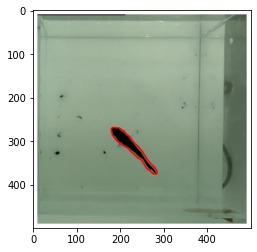

In [ ]:
for i in range(len(video_paths)):
  IMAGELENGTH=500
  fps=40

  args = Args()
  args.video_path = video_paths[i]
  args.h5_path = h5_paths[i]
  #args.manual_path = manual_paths[i]
  videopath = args.video_path
  video_path = videopath
  #manual_path = args.manual_path
  h5_path = args.h5_path
  #manual_flare = pd.read_excel(manual_path)
  #manual_flare = pd.DataFrame(manual_flare,dtype = int)
  start = 72000
  stop = 144000     
  fish_name = ".".join(os.path.basename(video_path).split(".")[:-1])
  output_dir = os.path.join(args.output_root,fish_name)
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
  
  #if i == 1:
  def pre_filter(x):
    out = x.copy()
    out[:10,:] = 255
    out[-10:,:] = 255
    out[:,:10] = 255
    out[:,-10:] = 255
    #out[:70,350:] = 255
    return out
  '''
  elif i == 2:
    def pre_filter(x):
      out = x.copy()
      out[:10,:] = 255
      out[-10:,:] = 255
      out[:,:10] = 255
      out[:,-10:] = 255
      out[:60,:200] = 255
      return out
  
  else:
    def pre_filter(x):
      out = x.copy()
      out[:20,:] = 255
      out[-20:,:] = 255
      out[:,:20] = 255
      out[:,-20:] = 255   
      return out
  '''
  path = h5_path
  f = pd.HDFStore(path,'r')
  df = f.get('df_with_missing')
  df.columns = df.columns.droplevel()
  df=df.iloc[start:stop,:]
  new_features=features(starttime=0,endtime=stop-start)
  filtered_df=new_features.filter_df(df,add_midpoint=True)
  #filtered_head=relative_position_check(filtered_df.A_head)
  filtered_head=df.A_head
  filtered_head=filtered_head.fillna(method="ffill")
  filtered_head=filtered_head.fillna(method="bfill") #just to make sure no NAs
  new_features.fit(filtered_df)
  features_df,_,_,_ = new_features.export_df()
  features_df.to_csv(os.path.join(output_dir,"base_features.csv"),index = False)

  #get a better contour using head position from DLC and thresholding again.
  #the previous mask is also needed to remove some noise near fish's contour caused by raising the threshold
  new_contour_array=find_contour(video_path,filtered_head,start=start,length = stop - start,step=1,threshold = args.thres,shrink_kernel = args.shrink_kernel,pre_filter = pre_filter)
  with open(os.path.join(output_dir,"refined_contour"), "wb") as fp:
      pickle.dump(new_contour_array, fp)

  decorated_result = cv2.VideoWriter(os.path.join(output_dir,"valid_video0.mp4"),cv2.VideoWriter_fourcc(*'mp4v'), fps, (IMAGELENGTH,IMAGELENGTH))
  i = 0
  cap = cv2.VideoCapture(videopath) 
  index = start
  cap.set(1,index)
  while True:
      ret, frame = cap.read() 
      if not ret or index >= min(start+10000,stop):
          break
      if (index - start) %1000 == 0:
        print("current index {}".format(index))
      frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
      '''
      if flag==0:
          print("no valid fish contour find at index {}".format(index))
          img=np.float32(np.full(frame.shape,0))#just in case there's no valid contour, won't happen in the current case
      else:
          #draw only the mask of this contour
          img=cv2.drawContours(np.float32(np.full(frame.shape,255)),[fish_contour],0,(0,0,0),cv2.FILLED)
      '''
      cur_contour = new_contour_array[i]
      frame = cv2.drawContours(frame,[cur_contour],0,(255,0,0),2)
      decorated_result.write(frame)
      index += 1
      i += 1
  decorated_result.release()
  print("complete extract contour")  
  #find head and tail position
  curve_scores=[]
  tail_indexs=[]
  better_head_indexs=[]
  lengths=[]
  head_x=np.array(filtered_head.x)
  head_y=np.array(filtered_head.y)
  #no interpolate this time, contour coordinates should be within 0-500
  for i in tqdm(range(len(new_contour_array))):
      contour=new_contour_array[i]
      head_index=head_on_contour(head_x[i], head_y[i], contour)
      better_head_index,tail_index,curve_score,length=predict_tail(contour,head_index,step=[33,57],neighbor_width=[17,17],minimal_seg_length=15)
      tail_indexs.append(tail_index)
      curve_scores.append(curve_score)
      lengths.append(length)
      better_head_indexs.append(better_head_index)

  head_indexs=pd.Series(better_head_indexs).fillna(method="ffill").fillna(method = "bfill").astype(int)
  tail_indexs=pd.Series(tail_indexs).fillna(method="ffill").fillna(method = "bfill").astype(int)
      
  with open(os.path.join(output_dir,"curve_scores"), "wb") as fp:
      pickle.dump(curve_scores, fp)
      
  with open(os.path.join(output_dir,"tail_index"), "wb") as fp:
      pickle.dump(tail_indexs.tolist(), fp)   
      
  with open(os.path.join(output_dir,"head_index"), "wb") as fp:
      pickle.dump(head_indexs.tolist(), fp)    

  with open(os.path.join(output_dir,"fish_segment_length"), "wb") as fp:
      pickle.dump(lengths, fp)       
      
  print("tail feature extracted!")
  tail_angles=[]
  tail_devs=[]
  for i in range(len(new_contour_array)):
      contour=curve_scores[i][:,:2]
      contour=contour.squeeze()
      head_index=head_indexs[i]
      tail_index=tail_indexs[i]
      tail_angle,tail_dev=compute_TailAngle_Dev(head_index,tail_index,contour)
      tail_angles.append(tail_angle)
      tail_devs.append(tail_dev)
  tail_angles=np.array(tail_angles)
  tail_devs=np.array(tail_devs)

  with open(os.path.join(output_dir,"tailAngle"),"wb") as fp:
      pickle.dump(tail_angles, fp)    

  with open(os.path.join(output_dir,"tail_dev"), "wb") as fp:
      pickle.dump(tail_devs, fp)    

  #make validation video
  decorated_result = cv2.VideoWriter(os.path.join(output_dir,"valid_video.mp4"),cv2.VideoWriter_fourcc(*'mp4v'), fps, (IMAGELENGTH,IMAGELENGTH))
  i = 0
  cap = cv2.VideoCapture(videopath) 
  index = start
  cap.set(1,index)
  while True:
      ret, frame = cap.read() 
      if not ret or index >= min(start+10000,stop):
          break
      if (index - start) %1000 == 0:
        print("current index {}".format(index))
      frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
      '''
      if flag==0:
          print("no valid fish contour find at index {}".format(index))
          img=np.float32(np.full(frame.shape,0))#just in case there's no valid contour, won't happen in the current case
      else:
          #draw only the mask of this contour
          img=cv2.drawContours(np.float32(np.full(frame.shape,255)),[fish_contour],0,(0,0,0),cv2.FILLED)
      '''
      cur_contour = new_contour_array[i]
      cur_contour = np.array(cur_contour,dtype = np.int32)
      #cur_head_index = head_indexs.iloc[i]
      cur_tail_index = tail_indexs.iloc[i]
      l = len(cur_contour)
      head_x,head_y = filtered_head.x.iloc[i],filtered_head.y.iloc[i]
      #head_x,head_y = new_contour_array[i][cur_head_index%l][0]
      tail_x,tail_y = new_contour_array[i][cur_tail_index%l][0]
      
      frame = cv2.circle(frame, (int(head_x),int(head_y)), 5, (0,0,255), -1)
      frame = cv2.circle(frame, (int(tail_x),int(tail_y)), 5, (0,255,0), -1)
      frame = cv2.drawContours(frame,[cur_contour],0,(255,0,0),2)
      decorated_result.write(frame)
      index += 1
      i += 1
  decorated_result.release()